# 2. Single-line experiment
This experiment trains the models on 11 mice, all from the same breed and tests the models on 1 different mouse from the same breed

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifierCV, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.optimizers import Adam

from tqdm.notebook import tqdm
from tqdm.keras import TqdmCallback

import lib.features as features
import lib.breeds as breeds
import lib.plots as plots
import lib.models as models

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [2]:
data_folder = '../data/csv/'
data_files = [mice + ".smo.csv" for mice in breeds.mice_breeds["c57bl6"]][:]
data_files_train = data_files[:-1]
data_files_test = data_files[-1:]

print(f"Training on {data_files_train}")
print(f"Testing on {data_files_test}")

days = [0, 1, 2, 3]
window_sizes = [2, 5, 10, 20, 50, 100]
window_features = ["EEGv", "EMGv"]
spectral=True
rolloffs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
test_size = 0.3
useRaw = False
dropBins = True
cat_matrix = True # True for neural net, any for random forest
standardize_df = False

lr=1e-4
epochs=150
batch_size=64

seed = 13

Training on ['BL601.smo.csv', 'BL602.smo.csv', 'BL606.smo.csv', 'BL609.smo.csv', 'BL610.smo.csv', 'BL611.smo.csv', 'BL612.smo.csv', 'BL614.smo.csv', 'BL616.smo.csv', 'BL6V1.smo.csv', 'BL6V2.smo.csv']
Testing on ['BL6V3.smo.csv']


In [3]:
# train and test on same mice
df_train = features.clean_data(
    data_folder=data_folder, 
    data_files=data_files_train,
    days=days, 
    window_sizes=window_sizes, 
    window_features=window_features,
    spectral=spectral,
    rolloffs=rolloffs,
    dropBins=dropBins, 
    useRaw=useRaw, 
    balance=True, 
    standardize_df=standardize_df,
    seed=seed,
)

df_test = features.clean_data(
    data_folder=data_folder, 
    data_files=data_files_test,
    days=days, 
    window_sizes=window_sizes, 
    window_features=window_features,
    spectral=spectral,
    rolloffs=rolloffs,
    dropBins=dropBins, 
    useRaw=useRaw, 
    balance=False, 
    standardize_df=standardize_df,
    seed=seed,
)

x_train, x_test, y_train, y_test, le = features.encode_scale_data(df_train=df_train, df_test=df_test, useRaw=useRaw, seed=seed, cat_matrix=cat_matrix)

# Neural Network

In [4]:
model = models.nn_baseline_model(x_train.shape[1], le.classes_.size, lr=lr)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 3)                 246       
                                                                 
 dense_1 (Dense)             (None, 3)                 12        
                                                                 
Total params: 258
Trainable params: 258
Non-trainable params: 0
_________________________________________________________________


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

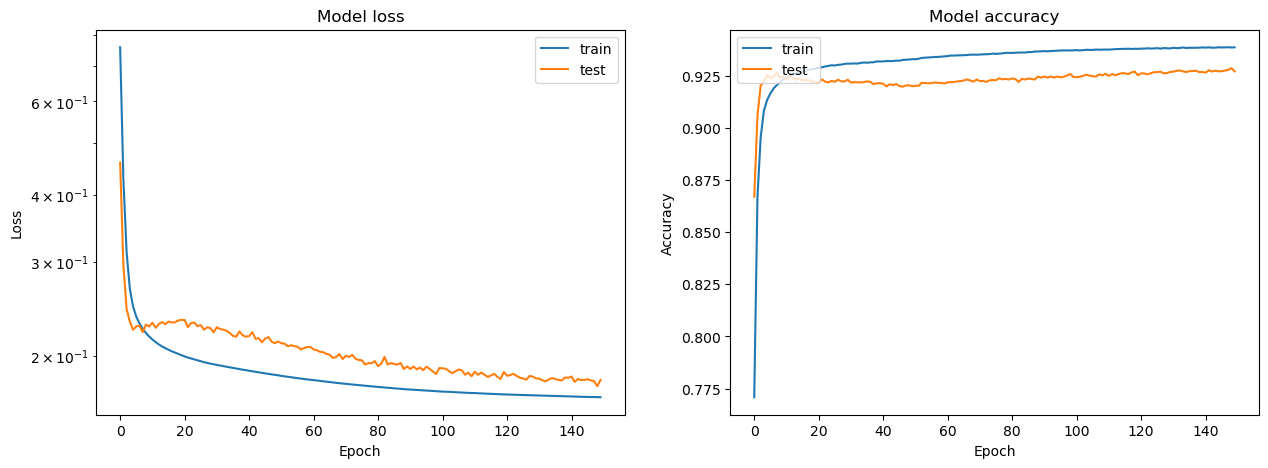

In [5]:
model = models.nn_baseline_model(x_train.shape[1], le.classes_.size, lr=lr)
history = model.fit(x=x_train,
                    y=y_train,
                    validation_data=(x_test, y_test),
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=0,
                    callbacks=[TqdmCallback(verbose=1)]
                )

plots.plot_history(history.history)

2644/2644 [==============================] - 2s 615us/step
[[29913  1347   332]
 [   39  3782    26]
 [  497  3915 44730]]
              precision    recall  f1-score   support

           n       0.98      0.95      0.96     31592
           r       0.42      0.98      0.59      3847
           w       0.99      0.91      0.95     49142

    accuracy                           0.93     84581
   macro avg       0.80      0.95      0.83     84581
weighted avg       0.96      0.93      0.94     84581



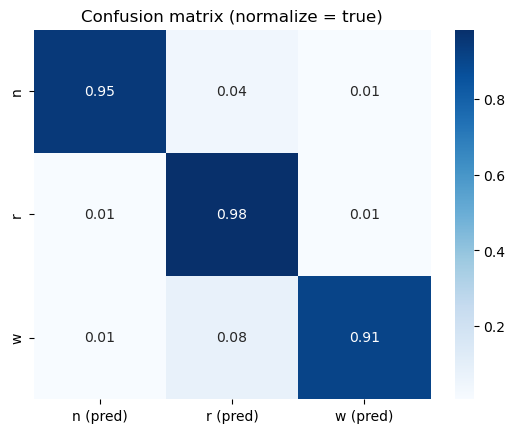

In [6]:
plots.plot_confusion(model=model, x_test=x_test, y_test=y_test, le=le, cat_matrix=True, normalize='true')

# Random Forest

[[30421  1033   138]
 [   79  3763     5]
 [ 1127  1944 46071]]
              precision    recall  f1-score   support

           n       0.96      0.96      0.96     31592
           r       0.56      0.98      0.71      3847
           w       1.00      0.94      0.97     49142

    accuracy                           0.95     84581
   macro avg       0.84      0.96      0.88     84581
weighted avg       0.96      0.95      0.95     84581



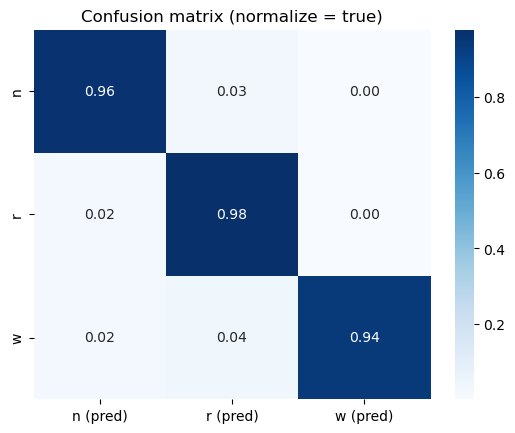

In [7]:
rfc = RandomForestClassifier(random_state=seed)
rfc.fit(x_train, y_train)
y_predict = rfc.predict(x_test)
plots.plot_confusion(model=rfc, x_test=x_test, y_test=y_test, le=le, cat_matrix=cat_matrix, normalize='true')